In [ ]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)


In [2]:
import h5py

with h5py.File("/eos/user/c/castaned/ntuple_merged_25.h5", "r") as f:
    for key in f.keys():
        print(f"Dataset: {key}, Shape: {f[key].shape}, Type: {f[key].dtype}")        

Dataset: A_Dr_Z, Shape: (400000,), Type: float32
Dataset: A_Zmass, Shape: (400000,), Type: float32
Dataset: B_Dr_Z, Shape: (400000,), Type: float32
Dataset: B_Zmass, Shape: (400000,), Type: float32
Dataset: C_Dr_Z, Shape: (400000,), Type: float32
Dataset: C_Zmass, Shape: (400000,), Type: float32
Dataset: D_Dr_Z, Shape: (400000,), Type: float32
Dataset: D_Zmass, Shape: (400000,), Type: float32
Dataset: Dataset_ID, Shape: (400000,), Type: float32
Dataset: Electron_charge, Shape: (400000, 10), Type: float32
Dataset: Electron_cutBased, Shape: (400000, 10), Type: float32
Dataset: Electron_eta, Shape: (400000, 10), Type: float32
Dataset: Electron_phi, Shape: (400000, 10), Type: float32
Dataset: Electron_pt, Shape: (400000, 10), Type: float32
Dataset: MET_pt, Shape: (400000,), Type: float32
Dataset: Muon_charge, Shape: (400000, 10), Type: float32
Dataset: Muon_eta, Shape: (400000, 10), Type: float32
Dataset: Muon_highPtId, Shape: (400000, 10), Type: float32
Dataset: Muon_isGlobal, Shape: (400

### Define the list of variables from the h5 file to use as features, spectator and labels

In [12]:
# 27 features
features = ['A_Dr_Z',
            'A_Zmass',
            'MET_pt',
            'B_Zmass',
            'B_Dr_Z'
           ]

# spectators to define mass/pT window
# spectators = ['fj_sdmass',
#               'fj_pt']

#
labels = ['Dataset_ID']

nfeatures = len(features)
# nspectators = len(spectators)
# nlabels = len(labels)

In [13]:
features

['A_Dr_Z', 'A_Zmass', 'MET_pt', 'B_Zmass', 'B_Dr_Z']

In [14]:
def get_features_labels(file_name):
   
    h5file = tables.open_file(file_name, 'r')

    nevents = getattr(h5file.root, features[0]).shape[0]  # Tomar el número de eventos del primer feature

    feature_array = np.zeros((nevents, nfeatures * 10))  # Cada feature tiene 10 valores por evento

     # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # Define which Dataset_ID values correspond to background (QCD)
    bkg_ids = {2, 3, 4,5}  # Modify with actual background IDs

    # Load labels arrays
    for (i, label) in enumerate(labels):
        dataset_id_array = getattr(h5file.root, label)[:]  # Load Dataset_ID from HDF5
        label_array[:, 0] = np.isin(dataset_id_array, list(bkg_ids)).astype(int)  # Background
        label_array[:, 1] = 1 - label_array[:, 0]  # Signal
    
    h5file.close()
    return feature_array, label_array

In [15]:


# load training file
feature_array = get_features_labels('/eos/user/c/castaned/ntuple_merged_25.h5')
print(feature_array.shape)
print(label_array.shape)

In [18]:
# Divide train and validation+test
X_train, X_temp = train_test_split(feature_array, test_size=0.2, random_state=42, shuffle=True)

# Divide validation+test in validation and test
X_valid, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

### Load the data (numpy.array) into a DatasetLoad (Tensor)

In [19]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [20]:
ae_train_ds = SensorDataset(X_train)
ae_valid_ds = SensorDataset(X_valid)
ae_test_ds = SensorDataset(X_test)

In [21]:
ae_train_ds[3]

tensor([  0.0000,   0.0000, 120.6265,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000])

In [22]:
class Autoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.SELU(),
            nn.Linear(64, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.smooth_l1_loss(output, input)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.smooth_l1_loss(output, input)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        output = self.forward(input)
        return output

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-5)

#### PyTorch Progress Bar Implementation

In [23]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

In [24]:
in_dim = ae_train_ds.dataset.shape[1]
model = Autoencoder(in_dim)

batch_size = 32
ae_tdl, ae_vdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(ae_valid_ds, batch_size=batch_size, num_workers=4)

In [ ]:
es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=5)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="auto")
#trainer.fit(model, train_dataloaders=ae_tdl)
trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 6.1 K  | train
1 | decoder | Sequential | 6.1 K  | train
-----------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
Epoch 4:  72%|███████▏  | 7163/10000 [09:46<02:55, 16.19it/s, loss=0.2404]

### Loss curve

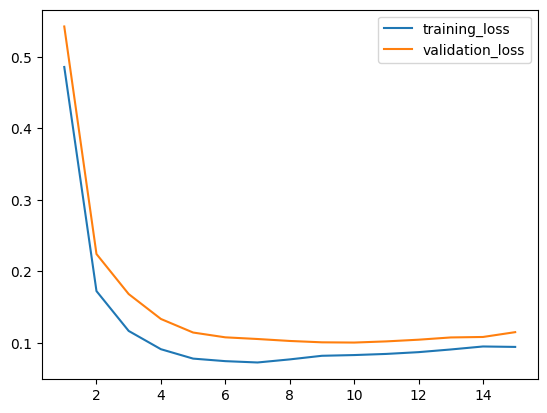

In [17]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

In [18]:
print(cp.best_model_path)
print(cp.best_model_score)
model = Autoencoder.load_from_checkpoint(cp.best_model_path)

/LUSTRE/home/ccd/VAE_anomalyHEP/examples/AEs/checkpoints/epoch=9-step=50000-v1.ckpt
tensor(0.1005)


### AE Result Visualization

/LUSTRE/home/ccd/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


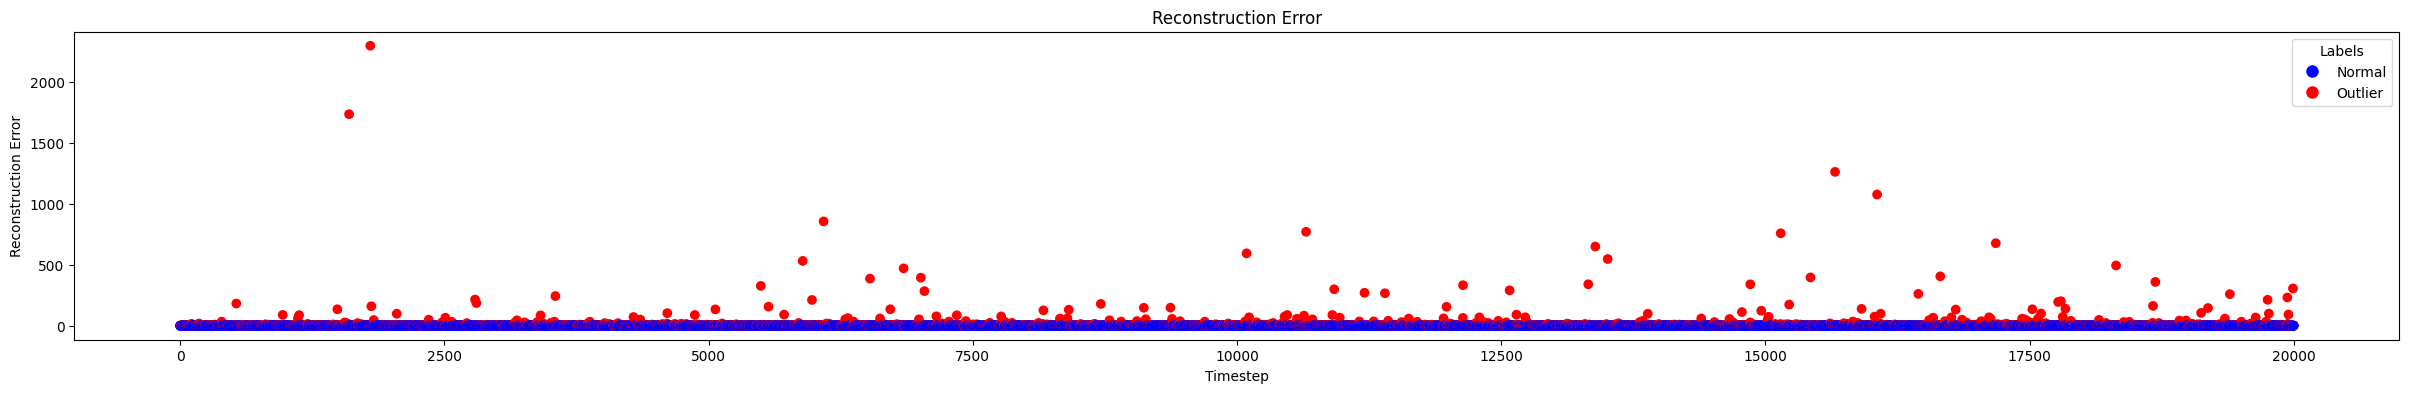

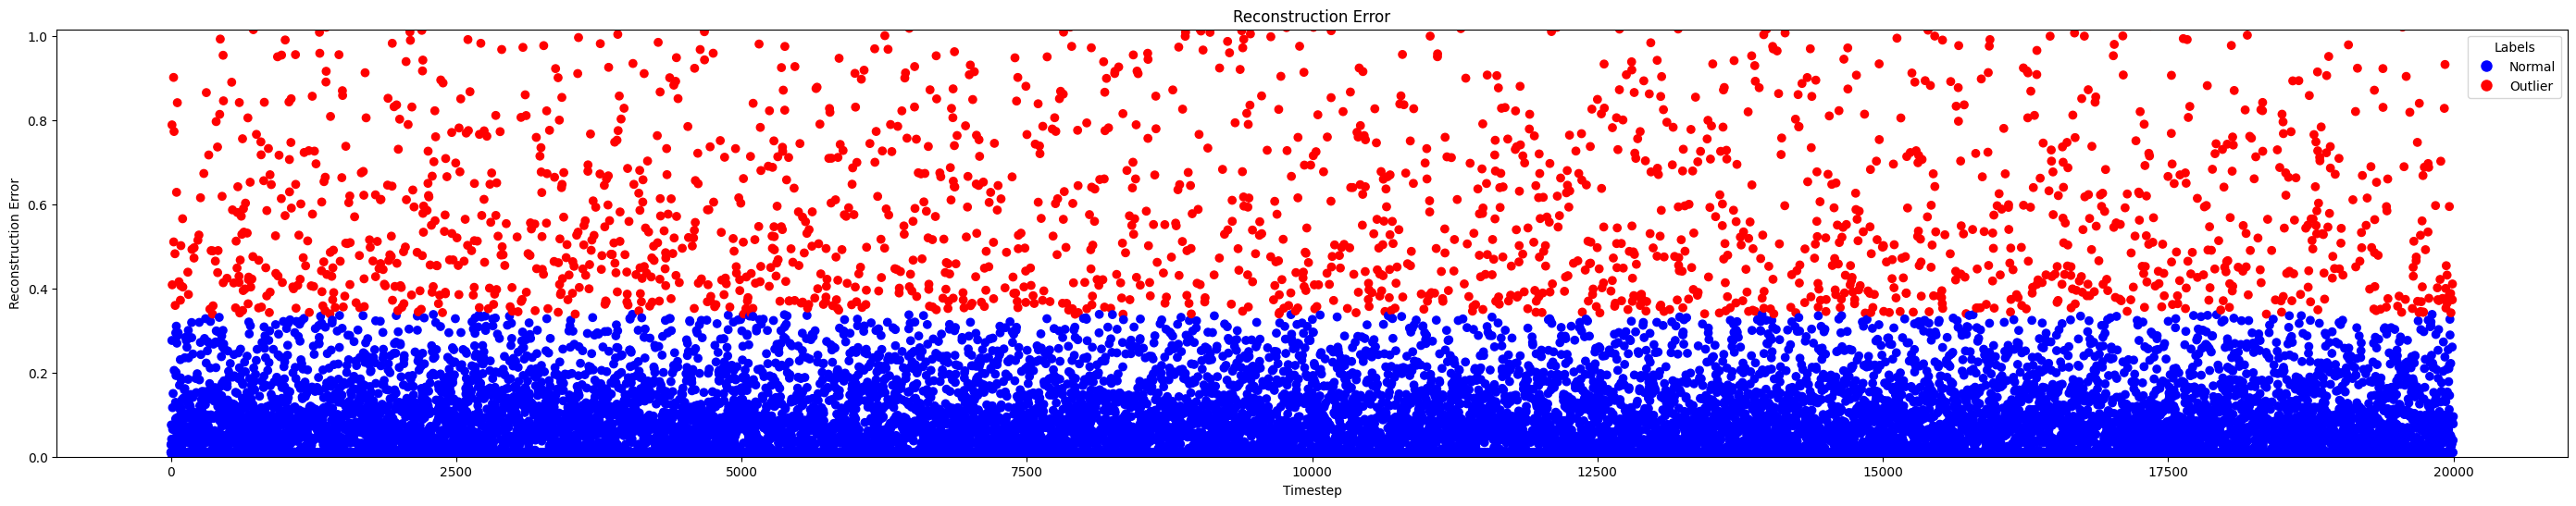

In [19]:
test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
# Definir el umbral 
#threshold = np.median(reco) * 5 

# Identificar los puntos anómalos
#test_label_colors = np.where(reco > threshold, 'red', 'blue')  

label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()